Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
47/47 [==============================] - 1s 2ms/step - loss: 104.1824
Epoch 2/1000
47/47 [==============================] - 0s 1ms/step - loss: 70.0588
Epoch 3/1000
47/47 [==============================] - 0s 1ms/step - loss: 60.5685
Epoch 4/1000
47/47 [==============================] - 0s 1ms/step - loss

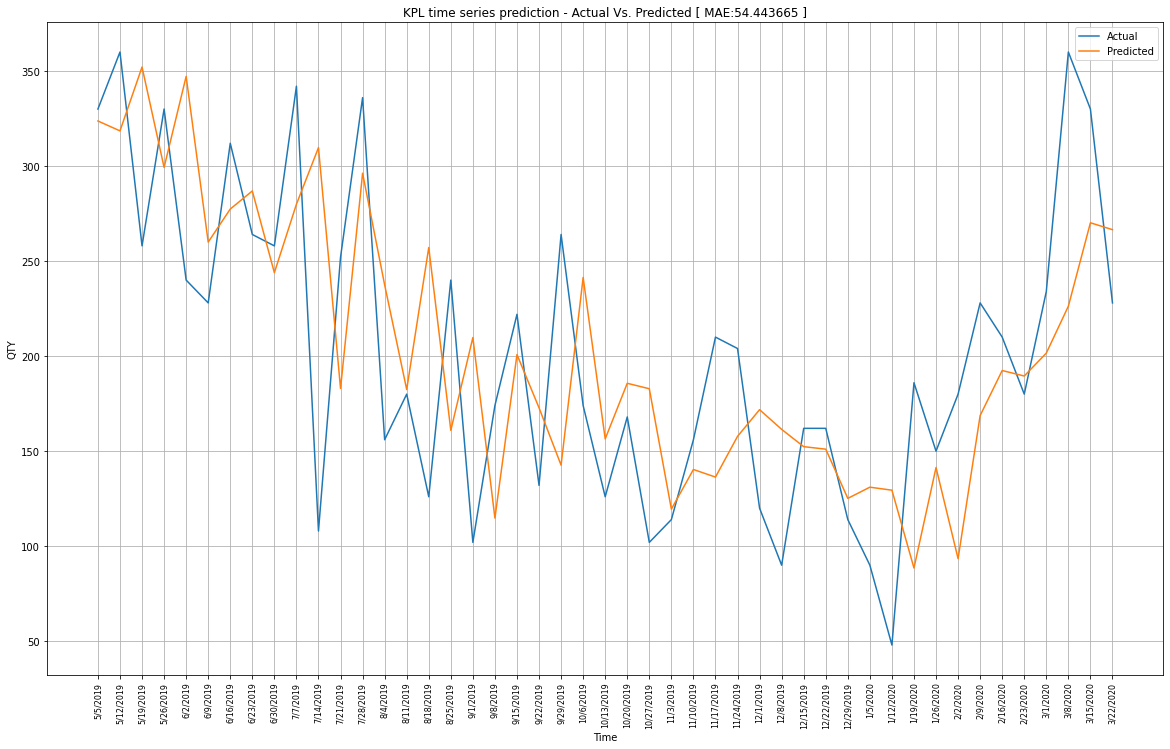

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
22/22 [==============================] - 1s 4ms/step - loss: 187.0732
Epoch 2/1000
22/22 [==============================] - 0s 1ms/step - loss: 147.7340
Epoch 3/1000
22/22 [==============================] - 0s 1ms/step - loss: 95.8696
Epoch 4/1000
22/22 [==============================] - 0s 1ms/step - los

InvalidArgumentError: Incompatible shapes: [47] vs. [43] [Op:Sub]

In [6]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(20, 8))
    plt.xticks(rotation=90, size=8)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()
time_step = []
qty = []
with open('Mean_WEEK-WISE_FGAS-660A-16-00087B4covid.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i in reader:
    qty.append(int(i[1]))
    time_step.append((i[0]))
series = np.array(qty)
time = np.array(time_step)
# plot_series(time, series)
# split_time = int(1 * len(series))
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]
time_train = time
x_train = series
for i in range(1, 52):
    window_size = 4
    batch_size = i
    shuffle_buffer_size = 55
    def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
      dataset = tf.data.Dataset.from_tensor_slices(series)
      dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
      dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
      dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
      dataset = dataset.batch(batch_size).prefetch(1)
      return dataset
    tf.keras.backend.clear_session()
    dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# relu | LeakyReLU | gelu | elu | selu | swish
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(8, input_shape=[window_size], activation="LeakyReLU"),
        tf.keras.layers.Dense(4, activation="LeakyReLU"),
        tf.keras.layers.Dense(1, activation="LeakyReLU")
    ])
    print(model.summary())
# opt adam | adagrad | Adadelta | RMSprop | SGD | momntum | NAG |
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model.compile(loss="mae", optimizer='adam')
    model.fit(dataset, epochs=1000, callbacks=[callback], verbose=1)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# # patience: Number of epochs with no improvement after which training will be stopped.
# # # LR
# history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
# plt.semilogx(history.history["lr"], history.history["loss"])
# # plt.axis([1e-8, 1e-4, 0, 800])
# plt.show()
    forecast = []
    for time in range(len(series)-window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
# forecast = forecast[:]
    results = np.array(forecast)[:,0,0]
# results = np.roll(results, +5)
# results = results[:]
# print('forecast:\n', forecast)
# print('results:\n', results)
    time_train = time_train[4:]
    x_train = x_train[4:]
    MAE = tf.keras.metrics.mean_absolute_error(x_train, results).numpy()
    print('MAE: ', MAE)
    plt.figure(figsize=(20, 12))
    plt.plot(time_train, x_train, label='Actual')
    plt.plot(time_train,results, label='Predicted')
    plt.title('KPL time series prediction - Actual Vs. Predicted [ MAE:'+str(MAE)+" ]")
    plt.xlabel("Time")
    plt.ylabel("QTY")
    plt.xticks(rotation=90, size=8)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig('Test b-'+str(i)+ 'img.jpg')
    plt.show()